# Essex Property Trust Price Prediction

In [91]:
import numpy as np
import optuna
import pandas as pd
from optuna import visualization as vis
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import mean_absolute_error, make_scorer
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

import utils

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Preparation

In [92]:
# Load the data
df = pd.read_csv('../data/final_data.csv')
df = df.drop(columns=['Unnamed: 0'])
# fix the typo in 3monhth_treasury_yield
df = df.rename(columns={'3monhth_treasury_yield': '3month_treasury_yield'})
df

,region_name,adjusted_average_new_listings,adjusted_average_new_listings_yoy,average_pending_sales_listing_updates,average_pending_sales_listing_updates_yoy,off_market_in_two_weeks,off_market_in_two_weeks_yoy,adjusted_average_homes_sold,adjusted_average_homes_sold_yoy,median_new_listing_price,...,AVB_adj_close_1month,AVB_adj_close_3month,INVH_adj_close,INVH_adj_close_1week,INVH_adj_close_1month,INVH_adj_close_3month,unemployment,fed_funds,3month_treasury_yield,cpi
0,Stanislaus County,163.0,0.108844,152.0,-0.061728,52.0,-0.187500,112.0,-0.157895,289000.0,...,143.5444,151.9891,17.9177,18.0851,18.0935,18.4117,0.044,0.000142,0.0066,2.43801
1,Stearns County,73.0,0.123077,42.0,0.000000,11.0,0.100000,31.0,0.033333,168500.0,...,143.5444,151.9891,17.9177,18.0851,18.0935,18.4117,0.044,0.000142,0.0066,2.43801
2,Denver County,335.0,-0.079670,313.0,-0.163102,162.0,0.045161,341.0,0.249084,399900.0,...,147.9058,142.9288,17.9080,17.7653,19.2879,19.3131,0.043,0.000216,0.0116,2.44786
3,Stanislaus County,120.0,-0.097744,165.0,0.071429,44.0,-0.185185,76.0,-0.296296,279975.0,...,143.2823,149.1924,17.7084,18.0851,18.0851,18.2942,0.046,0.000102,0.0066,2.43603
4,Stearns County,50.0,-0.107143,46.0,0.210526,6.0,0.500000,16.0,-0.238095,237450.0,...,143.2823,149.1924,17.7084,18.0851,18.0851,18.2942,0.046,0.000102,0.0066,2.43603
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125466,Cuyahoga County,397.0,-0.076744,405.0,-0.093960,150.0,-0.202128,292.0,-0.165714,202950.0,...,200.3976,221.9251,34.9415,34.8627,35.0894,35.6648,0.041,0.001032,0.0533,3.14175
125467,Butler County,14.0,-0.300000,15.0,-0.062500,6.0,0.200000,20.0,0.250000,243400.0,...,221.9251,216.2800,35.4068,35.0001,35.6648,31.4000,0.042,0.001001,0.0533,3.14796
125468,Schuylkill County,40.0,0.333333,34.0,0.096774,12.0,-0.076923,30.0,0.200000,124950.0,...,200.3976,221.9251,34.9415,34.8627,35.0894,35.6648,0.041,0.001032,0.0533,3.14175
125469,Aransas County,14.0,0.400000,14.0,0.555556,0.0,-1.000000,16.0,1.000000,389500.0,...,200.3976,221.9251,34.9415,34.8627,35.0894,35.6648,0.041,0.001032,0.0533,3.14175


In [ ]:
# describe the data
df.describe()

### Drop Columns

In [93]:
# Drop technical indicators
df = df.drop(columns=['SPY_adj_close', 'unemployment', 'fed_funds', '3month_treasury_yield', 'cpi'])

### Regional Filter

In [94]:
# include only rows where state is either California or Washington
df = df[(df['State'] == 'CA') | (df['State'] == 'WA')]
df.drop(columns=['date', 'State'], inplace=True)
df

,region_name,adjusted_average_new_listings,adjusted_average_new_listings_yoy,average_pending_sales_listing_updates,average_pending_sales_listing_updates_yoy,off_market_in_two_weeks,off_market_in_two_weeks_yoy,adjusted_average_homes_sold,adjusted_average_homes_sold_yoy,median_new_listing_price,...,ESS_adj_close_1month,ESS_adj_close_3month,AVB_adj_close,AVB_adj_close_1week,AVB_adj_close_1month,AVB_adj_close_3month,INVH_adj_close,INVH_adj_close_1week,INVH_adj_close_1month,INVH_adj_close_3month
0,Stanislaus County,163.0,0.108844,152.0,-0.061728,52.0,-0.187500,112.0,-0.157895,289000.0,...,182.8185,205.6963,137.0456,143.2823,143.5444,151.9891,17.9177,18.0851,18.0935,18.4117
3,Stanislaus County,120.0,-0.097744,165.0,0.071429,44.0,-0.185185,76.0,-0.296296,279975.0,...,181.2400,197.8955,137.6392,141.1238,143.2823,149.1924,17.7084,18.0851,18.0851,18.2942
7,Stanislaus County,156.0,0.200000,178.0,-0.037838,69.0,0.014706,127.0,-0.023077,285450.0,...,182.9360,208.5159,143.2823,143.8682,144.8729,151.4842,18.0851,18.0684,17.8256,17.9668
12,Stanislaus County,159.0,0.104167,185.0,0.209150,64.0,0.306122,144.0,0.345794,304500.0,...,184.4398,208.5707,143.8682,142.6355,145.0593,152.3465,18.0684,18.2777,18.1354,17.8240
18,Stanislaus County,49.0,0.166667,75.0,-0.193548,12.0,-0.294118,108.0,-0.175573,278000.0,...,178.8378,194.8639,140.5071,141.8549,134.1344,131.7889,19.7027,19.9310,18.7556,19.3638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125389,Kittitas County,19.0,-0.208333,17.0,-0.346154,5.0,-0.375000,25.0,0.190476,509995.0,...,295.7572,276.9700,208.8835,213.5979,221.9251,216.2800,35.4068,35.0001,35.6648,31.4000
125392,San Bernardino County,481.0,0.116009,477.0,0.171990,74.0,0.104478,360.0,0.052632,550000.0,...,311.4669,304.6600,213.5979,220.0691,232.9916,233.7500,35.0001,35.8632,36.7263,33.7000
125423,Imperial County,18.0,0.800000,28.0,-0.282051,7.0,0.750000,14.0,-0.481481,382250.0,...,261.7439,272.0736,181.2613,188.4673,195.7914,200.3976,33.0419,34.1738,34.8923,35.0894
125454,Snohomish County,298.0,0.585106,220.0,-0.185185,127.0,-0.196203,261.0,0.052419,749950.0,...,282.4476,311.4669,200.7135,205.3403,205.8167,232.9916,34.8627,35.6052,35.6350,36.7263


### Dummy Encoding

In [95]:
# One-hot encode the categorical features
df = pd.get_dummies(df, drop_first=True, dtype=int)
df

,adjusted_average_new_listings,adjusted_average_new_listings_yoy,average_pending_sales_listing_updates,average_pending_sales_listing_updates_yoy,off_market_in_two_weeks,off_market_in_two_weeks_yoy,adjusted_average_homes_sold,adjusted_average_homes_sold_yoy,median_new_listing_price,median_new_listing_price_yoy,...,region_name_Tehama County,region_name_Thurston County,region_name_Tulare County,region_name_Ventura County,region_name_Walla Walla County,region_name_Whatcom County,region_name_Whitman County,region_name_Yakima County,region_name_Yolo County,region_name_Yuba County
0,163.0,0.108844,152.0,-0.061728,52.0,-0.187500,112.0,-0.157895,289000.0,0.103053,...,0,0,0,0,0,0,0,0,0,0
3,120.0,-0.097744,165.0,0.071429,44.0,-0.185185,76.0,-0.296296,279975.0,0.097941,...,0,0,0,0,0,0,0,0,0,0
7,156.0,0.200000,178.0,-0.037838,69.0,0.014706,127.0,-0.023077,285450.0,0.047713,...,0,0,0,0,0,0,0,0,0,0
12,159.0,0.104167,185.0,0.209150,64.0,0.306122,144.0,0.345794,304500.0,0.016864,...,0,0,0,0,0,0,0,0,0,0
18,49.0,0.166667,75.0,-0.193548,12.0,-0.294118,108.0,-0.175573,278000.0,0.029639,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125389,19.0,-0.208333,17.0,-0.346154,5.0,-0.375000,25.0,0.190476,509995.0,-0.036837,...,0,0,0,0,0,0,0,0,0,0
125392,481.0,0.116009,477.0,0.171990,74.0,0.104478,360.0,0.052632,550000.0,0.070020,...,0,0,0,0,0,0,0,0,0,0
125423,18.0,0.800000,28.0,-0.282051,7.0,0.750000,14.0,-0.481481,382250.0,0.103971,...,0,0,0,0,0,0,0,0,0,0
125454,298.0,0.585106,220.0,-0.185185,127.0,-0.196203,261.0,0.052419,749950.0,0.119328,...,0,0,0,0,0,0,0,0,0,0


### Splitting Data

In [96]:
# Split the data into features and target
X = df.drop(columns=['EQR_adj_close_1week', 'ESS_adj_close_1week', 'AVB_adj_close_1week', 'INVH_adj_close_1week',
                     'EQR_adj_close', 'ESS_adj_close', 'AVB_adj_close', 'INVH_adj_close', 'EQR_adj_close_1month',
                     'ESS_adj_close_1month', 'AVB_adj_close_1month', 'INVH_adj_close_1month', 'EQR_adj_close_3month',
                     'ESS_adj_close_3month', 'AVB_adj_close_3month', 'INVH_adj_close_3month'])
y = df['ESS_adj_close_3month']

### Train-Test Split

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Modeling

In [359]:
# define scorer and cross-validation
scorer = make_scorer(mean_absolute_error, greater_is_better=False)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
n_trials = 15

### Random Forest

#### Hyperparameter Tuning

In [131]:
# Hyperparameter search space
def objective(trial):
    # Hyperparameter search space
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    max_depth = trial.suggest_int('max_depth', 2, 8)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])

    # Create the Random Forest model with suggested hyperparameters
    rf = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )

    scores = cross_val_score(rf, X_train, y_train, scoring=scorer, cv=cv, n_jobs=-1)

    return -np.mean(scores)

In [132]:
study_rf = optuna.create_study(direction='minimize', study_name='rf_tuning')
study_rf.optimize(objective, n_trials=n_trials, show_progress_bar=True)

[I 2024-12-09 15:06:56,425] A new study created in memory with name: rf_tuning


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-12-09 15:06:59,404] Trial 0 finished with value: 25.420972759499808 and parameters: {'n_estimators': 251, 'max_depth': 6, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 25.420972759499808.
[I 2024-12-09 15:07:02,472] Trial 1 finished with value: 23.552023003693268 and parameters: {'n_estimators': 215, 'max_depth': 8, 'min_samples_split': 6, 'min_samples_leaf': 7, 'max_features': 'sqrt'}. Best is trial 1 with value: 23.552023003693268.
[I 2024-12-09 15:07:05,225] Trial 2 finished with value: 24.581943061306383 and parameters: {'n_estimators': 263, 'max_depth': 8, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 1 with value: 23.552023003693268.
[I 2024-12-09 15:07:20,579] Trial 3 finished with value: 28.840253180298184 and parameters: {'n_estimators': 394, 'max_depth': 2, 'min_samples_split': 7, 'min_samples_leaf': 6, 'max_features': None}. Best is trial 1 with value: 23.552023003693268.
[

In [133]:
vis.plot_optimization_history(study_rf).show()
vis.plot_param_importances(study_rf).show()

#### Model Training

In [134]:
# Get the best hyperparameters
best_params_rf = study_rf.best_params

In [135]:
# Create the Random Forest model with best hyperparameters
rf = RandomForestRegressor(
    n_estimators=best_params_rf['n_estimators'],
    max_depth=best_params_rf['max_depth'],
    min_samples_split=best_params_rf['min_samples_split'],
    min_samples_leaf=best_params_rf['min_samples_leaf'],
    max_features=best_params_rf['max_features'],
    random_state=42
)

In [136]:
# Fit the model
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=8, max_features=None, min_samples_leaf=5,
                      min_samples_split=8, n_estimators=468, random_state=42)

#### Model Evaluation

In [137]:
y_pred_rf_train = rf.predict(X_train)
y_pred_rf_test = rf.predict(X_test)

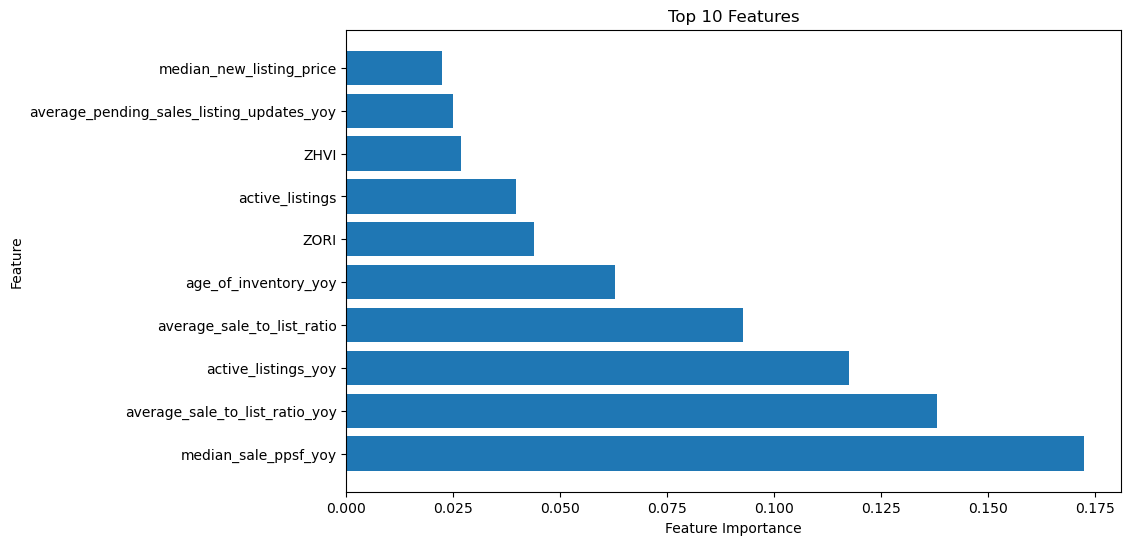

In [149]:
# plot top 10 features
plt.figure(figsize=(10, 6))
plt.barh(X.columns[np.argsort(rf.feature_importances_)[::-1][:10]],
            rf.feature_importances_[np.argsort(rf.feature_importances_)[::-1][:10]])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 10 Features')
plt.show()

### AdaBoost

#### Hyperparameter Tuning

In [139]:
def objective(trial):
    # Hyperparameter search space for the base Decision Tree
    max_depth = trial.suggest_int('max_depth', 1, 5)  # Depth of the tree
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)  # Minimum samples to split a node
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)  # Minimum samples in a leaf node
    max_features = trial.suggest_categorical('max_features',
                                             [None, 'sqrt', 'log2'])  # Features to consider for splitting

    # Hyperparameter search space for AdaBoost
    n_estimators = trial.suggest_int('n_estimators', 50, 500)
    learning_rate = trial.suggest_float('learning_rate', 0.01, 1.0, log=True)

    # Define the base estimator (Decision Tree)
    base_estimator = DecisionTreeRegressor(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        random_state=42
    )

    # Define the AdaBoost model
    model = AdaBoostRegressor(
        estimator=base_estimator,
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        random_state=42
    )

    scores = cross_val_score(model, X_train, y_train, scoring=scorer, cv=cv, n_jobs=-1)

    return -scores.mean()

In [140]:
# Optimize hyperparameters
study_ada = optuna.create_study(direction='minimize', study_name='ada_tuning')
study_ada.optimize(objective, n_trials=n_trials, show_progress_bar=True)

[I 2024-12-09 15:15:10,576] A new study created in memory with name: ada_tuning


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-12-09 15:15:19,821] Trial 0 finished with value: 28.394301421186764 and parameters: {'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'n_estimators': 467, 'learning_rate': 0.06933633346624479}. Best is trial 0 with value: 28.394301421186764.
[I 2024-12-09 15:15:22,380] Trial 1 finished with value: 29.503992002753556 and parameters: {'max_depth': 4, 'min_samples_split': 4, 'min_samples_leaf': 10, 'max_features': 'log2', 'n_estimators': 407, 'learning_rate': 0.3504780947083592}. Best is trial 0 with value: 28.394301421186764.
[I 2024-12-09 15:15:25,090] Trial 2 finished with value: 28.582823159988266 and parameters: {'max_depth': 4, 'min_samples_split': 10, 'min_samples_leaf': 10, 'max_features': 'log2', 'n_estimators': 114, 'learning_rate': 0.058929507797823875}. Best is trial 0 with value: 28.394301421186764.
[I 2024-12-09 15:15:31,743] Trial 3 finished with value: 30.439721769562425 and parameters: {'max_depth': 1, 'min_samples_split': 7,

In [141]:
# Visualizations
vis.plot_optimization_history(study_ada).show()
vis.plot_param_importances(study_ada).show()

#### Model Training

In [142]:
# Get the best hyperparameters
best_params_ada = study_ada.best_params

In [143]:
# Create the AdaBoost model with best hyperparameters
dt = DecisionTreeRegressor(
    max_depth=best_params_ada['max_depth'],
    min_samples_split=best_params_ada['min_samples_split'],
    min_samples_leaf=best_params_ada['min_samples_leaf'],
    max_features=best_params_ada['max_features'],
    random_state=42
)

ab = AdaBoostRegressor(
    estimator=dt,
    n_estimators=best_params_ada['n_estimators'],
    learning_rate=best_params_ada['learning_rate'],
    random_state=42
)

In [144]:
# Fit the model
ab.fit(X_train, y_train)

AdaBoostRegressor(estimator=DecisionTreeRegressor(max_depth=4,
                                                  min_samples_leaf=2,
                                                  min_samples_split=5,
                                                  random_state=42),
                  learning_rate=0.013038410334837958, n_estimators=386,
                  random_state=42)

#### Model Evaluation

In [145]:
y_pred_ada_train = ab.predict(X_train)
y_pred_ada_test = ab.predict(X_test)

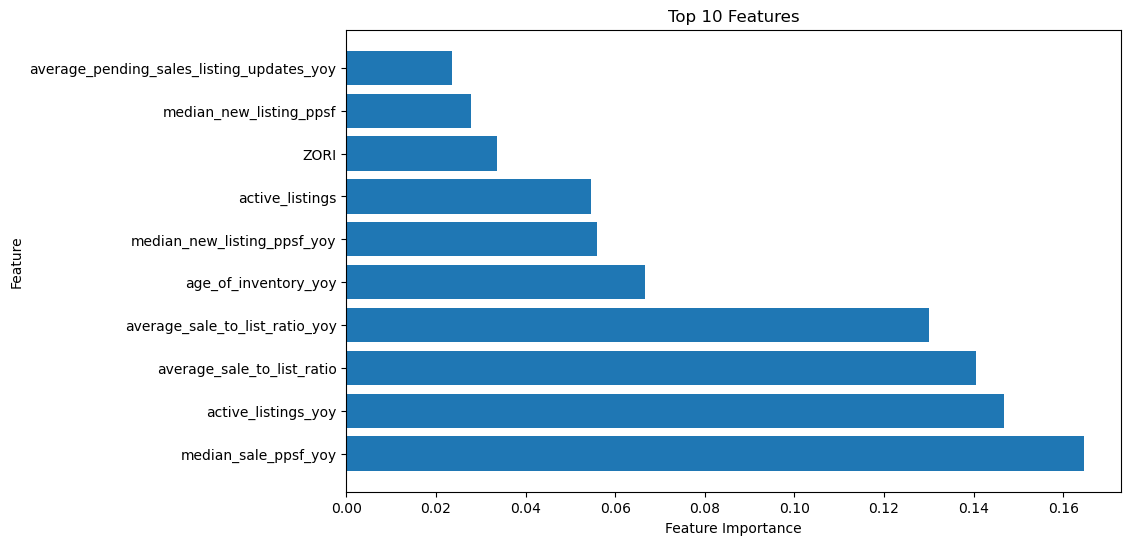

In [148]:
# plot top 10 features
plt.figure(figsize=(10, 6))
plt.barh(X.columns[np.argsort(ab.feature_importances_)[::-1][:10]],
            ab.feature_importances_[np.argsort(ab.feature_importances_)[::-1][:10]])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 10 Features')
plt.show()

### XGBoost

#### Hyperparameter Tuning

In [360]:
# Hyperparameter search space
def objective(trial):
    # Define the hyperparameter search space
    param = {
        "n_estimators": trial.suggest_int("n_estimators", 50, 500),
        "max_depth": trial.suggest_int("max_depth", 3, 6),
        "learning_rate": trial.suggest_float("learning_rate", 1e-4, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.3, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 0, 10),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 1),  # L1 regularization
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 5),  # L2 regularization
    }

    # Initialize XGBoost model
    model = XGBRegressor(random_state=42, **param)

    scores = cross_val_score(model, X_train, y_train, scoring=scorer, cv=cv, n_jobs=-1)

    return -scores.mean()

In [361]:
# Optimize hyperparameters
study_xg = optuna.create_study(direction='minimize', study_name='xg_tuning')
study_xg.optimize(objective, n_trials=n_trials, show_progress_bar=True)

[I 2024-12-09 16:07:13,868] A new study created in memory with name: xg_tuning


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2024-12-09 16:07:14,924] Trial 0 finished with value: 18.93018508436267 and parameters: {'n_estimators': 105, 'max_depth': 6, 'learning_rate': 0.03662645368494438, 'subsample': 0.5018879094470805, 'colsample_bytree': 0.9957987933314969, 'gamma': 1.989433032313166, 'min_child_weight': 3, 'reg_alpha': 0.18390179428501263, 'reg_lambda': 0.28744027389863314}. Best is trial 0 with value: 18.93018508436267.
[I 2024-12-09 16:07:15,946] Trial 1 finished with value: 20.556564285251703 and parameters: {'n_estimators': 308, 'max_depth': 4, 'learning_rate': 0.02012830873338747, 'subsample': 0.9131448011664313, 'colsample_bytree': 0.970447303637185, 'gamma': 0.15719250526186723, 'min_child_weight': 7, 'reg_alpha': 0.4535019524220235, 'reg_lambda': 3.2159111705933507}. Best is trial 0 with value: 18.93018508436267.
[I 2024-12-09 16:07:17,555] Trial 2 finished with value: 30.41935308669536 and parameters: {'n_estimators': 299, 'max_depth': 6, 'learning_rate': 0.0006534706416090887, 'subsample': 0.

In [362]:
# Visualizations
vis.plot_optimization_history(study_xg).show()
vis.plot_param_importances(study_xg).show()

#### Model Training

In [363]:
# Get the best hyperparameters
best_params_xg = study_xg.best_params

In [364]:
# Initialize XGBoost model with best hyperparameters
xgb_model = XGBRegressor(
    random_state=42,
    **best_params_xg
)

In [365]:
# Fit the model
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8867828464377129, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=5.839268515076603,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.0939679084233065,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=7, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=228, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

#### Model Evaluation

In [366]:
y_pred_xgb_train = xgb_model.predict(X_train)
y_pred_xgb_test = xgb_model.predict(X_test)

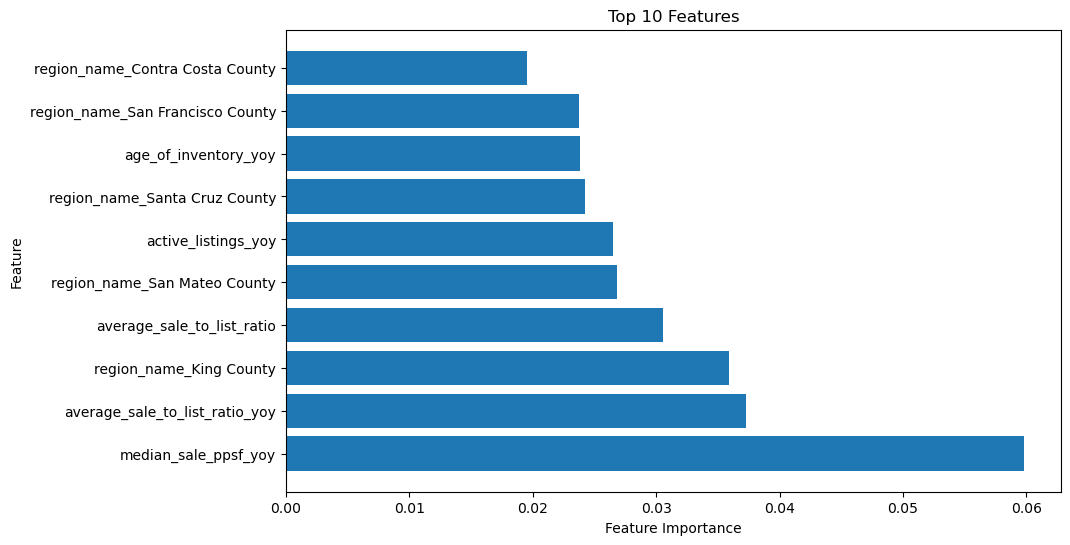

In [367]:
# plot top 10 features
plt.figure(figsize=(10, 6))
plt.barh(X.columns[np.argsort(xgb_model.feature_importances_)[::-1][:10]],
            xgb_model.feature_importances_[np.argsort(xgb_model.feature_importances_)[::-1][:10]])
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 10 Features')
plt.show()

## Conclusion

In [368]:
models = ['Random Forest', 'AdaBoost', 'XGBoost']
predictions_train = [y_pred_rf_train, y_pred_ada_train, y_pred_xgb_train]
predictions_test = [y_pred_rf_test, y_pred_ada_test, y_pred_xgb_test]

utils.evaluate_models(models=models, predictions_train=predictions_train, predictions_test=predictions_test, X=X,
                      y_train=y_train, y_test=y_test, task='regression')

,,Random Forest,AdaBoost,XGBoost
Metric,Type,,,
Mean Absolute Error,Train,17.928704,24.47712,8.950533
Mean Squared Error,Train,518.179399,859.59299,140.574455
Root Mean Squared Error,Train,22.763554,29.318816,11.85641
R-squared,Train,0.641403,0.405133,0.902718
Adjusted R-squared,Train,0.638398,0.400148,0.901903
Mean Absolute Error,Test,19.936401,24.805137,13.931076
Mean Squared Error,Test,642.462144,886.207739,333.17377
Root Mean Squared Error,Test,25.346837,29.769241,18.253048
R-squared,Test,0.560078,0.393175,0.771861
